# Homework 10 - IANNwTF - January 26, 2023

### Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow_text

In [3]:
import re
import tensorflow as tf
import numpy as np
import math
import tensorflow_text as tf_text
import tqdm.notebook as note
import scipy
import time

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus :
  #Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try :
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e :
    #Virtual devices must be set before GPUs have been initialized
    print(e)

In [8]:
# %cd drive/MyDrive/Github/IANNWTF_hw/HW_10
# %ls

/content/drive/MyDrive/Github/IANNWTF_hw/HW_10
data/  IANNwTF_homework10.pdf  seq2seq.PNG  SkipGram.ipynb


### 2.1 Dataset

In [9]:
#read bible text
bible = open("data/bible.txt", "r")
data = bible.read()

### 2.2 Word Embeddings

In [10]:
#lower characters and no special chars or digits, line breake to space
data = data.replace("\n", " ")
data = data.lower()
data = re.sub(r"[^a-z ]", "", data)
#create a smaller sample to see if everything works
smaller_data = data[:100000]
#create date set
tokens = list(smaller_data.split())

vocab, index = {}, 1  
vocab['<pad>'] = 0
for token in tokens:
  if token not in vocab:
    vocab[token] = index
    index += 1

vocab_size = len(vocab)
inverse_vocab = {index: token for token, index in vocab.items()}
sequence = [vocab[word] for word in tokens]
print(len(sequence))

19883


In [11]:
smaller_data

'the first book of moses  called genesis    in the beginning god created the heaven and the earth   and the earth was without form and void and darkness was upon the face of the deep and the spirit of god moved upon the face of the  waters   and god said let there be light and there was light   and god saw the light that it was good and god divided the light from the darkness   and god called the light day and the darkness he called night and the evening and the morning were the first day   and god said let there be a firmament in the midst of the waters and let it divide the waters from the waters   and god made the firmament and divided the waters which were under the firmament from the waters which were above the firmament and it was so   and god called the firmament heaven and the evening and the morning were the second day   and god said let the waters under the heaven be gathered together unto one place and let the dry land appear and it was so   and god called the dry land earth

In [12]:
# size of sampling windows (technically half-window). The window of a word w_i will be [i - window_size, i + window_size+1].
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      sequence,
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=0)
print(len(positive_skip_grams))
positive_skip_grams;

79526


Usual preprocessing steps :

In [13]:
BATCH_SIZE = 128 

In [14]:
smaller_dataset = positive_skip_grams
smaller_dataset = np.array(smaller_dataset)[:(len(smaller_dataset)//(BATCH_SIZE))*BATCH_SIZE]
smaller_dataset =tf.data.Dataset.from_tensor_slices((smaller_dataset[:,0],smaller_dataset[:,1]))
smaller_dataset = smaller_dataset.shuffle(1000).batch(128).prefetch(64)
smaller_dataset = smaller_dataset.map(lambda a,b: (a,tf.reshape(b,(-1,1))))
smaller_dataset

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

### The Model

In [15]:
class SkipGram(tf.keras.Model) :
  def __init__(self, vocabulary_size, embedding_size) :
    super(SkipGram, self).__init__()
    self.vocabulary_size = vocabulary_size
    self.embedding_size = embedding_size

  def build(self,input_shape) :
    self.embedding_matrix = tf.Variable(tf.random.uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0))
    self.score_weights = tf.Variable(tf.random.truncated_normal([self.vocabulary_size, self.embedding_size],stddev=1.0 / math.sqrt(self.embedding_size)))
    self.nce_biases = tf.Variable(tf.zeros([self.vocabulary_size])) 

  def call(self, words, labels) :
    embed = tf.nn.embedding_lookup(self.embedding_matrix, words)
    loss = tf.nn.nce_loss(weights=self.score_weights,biases=self.nce_biases, labels=labels,  inputs=embed, num_sampled=1 ,num_classes=self.vocabulary_size)
    
    return tf.reduce_mean(loss)

In [16]:
from scipy.spatial import distance

In [17]:
def nearest_words(Model, words_of_interest) :
    embed = Model.embedding_matrix.numpy()
    
    for word in words_of_interest :
        idx = vocab[word]
        closest = np.argmin( [distance.cosine(embed[idx],embed[q]) if q!=idx else np.inf for q in range(len(embed))] )
        print(f"Closest to {word} is {inverse_vocab[closest]}")

In [18]:
tf.keras.backend.clear_session()

interesting_words = ["beast", "father", "garden", "spirit", "naked", "woman", "day"]
num_epochs = 15
hidden_size = 64
VOCAB_SIZE = vocab_size
Model = SkipGram(VOCAB_SIZE,hidden_size)
optimizer = tf.optimizers.Adam(0.001)    
train_losses = np.empty(0)
start_time = time.time()

for epoch in range(num_epochs) :
    print(f'Epoch {str(epoch)}')
    epoch_loss_agg = np.empty(0)

    for input, target in note.tqdm(smaller_dataset,position=0,leave=True) :
      with tf.GradientTape() as tape :
        loss = Model(input,target) 
       
      gradients = tape.gradient(loss, Model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, Model.trainable_variables))
      epoch_loss_agg = np.append(epoch_loss_agg, loss)  
    train_losses = np.append(train_losses, tf.reduce_mean(epoch_loss_agg))            
                   
    used_time = np.round(time.time()-start_time)
    print(f"Finished epoch {epoch+1}, it took {used_time //60} minutes, {used_time%60} seconds")
    print(train_losses[-1])
    nearest_words(Model,interesting_words)
    start_time = time.time()

Epoch 0


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 1, it took 0.0 minutes, 41.0 seconds
5.712386654003039
Closest to beast is raamah
Closest to father is massa
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is sidon
Closest to woman is brick
Closest to day is camel
Epoch 1


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 2, it took 0.0 minutes, 29.0 seconds
5.392178332172154
Closest to beast is raamah
Closest to father is massa
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is sidon
Closest to woman is brick
Closest to day is camel
Epoch 2


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 3, it took 0.0 minutes, 24.0 seconds
4.752505265716193
Closest to beast is raamah
Closest to father is massa
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is sidon
Closest to woman is brick
Closest to day is camel
Epoch 3


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 4, it took 0.0 minutes, 29.0 seconds
4.891157992532096
Closest to beast is raamah
Closest to father is may
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is sidon
Closest to woman is to
Closest to day is camel
Epoch 4


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 5, it took 0.0 minutes, 27.0 seconds
4.079489465376989
Closest to beast is raamah
Closest to father is may
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is camel
Epoch 5


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 6, it took 0.0 minutes, 26.0 seconds
3.8986103651196293
Closest to beast is seed
Closest to father is may
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 6


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 7, it took 0.0 minutes, 26.0 seconds
3.621392516434289
Closest to beast is seed
Closest to father is may
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 7


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 8, it took 0.0 minutes, 27.0 seconds
3.529831272740391
Closest to beast is seed
Closest to father is sons
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 9, it took 0.0 minutes, 41.0 seconds
3.4386544675714728
Closest to beast is seed
Closest to father is sons
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 9


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 10, it took 0.0 minutes, 33.0 seconds
3.2582253341993463
Closest to beast is i
Closest to father is sons
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 10


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 11, it took 0.0 minutes, 34.0 seconds
3.1682220274483526
Closest to beast is seed
Closest to father is sons
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 11


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 12, it took 0.0 minutes, 36.0 seconds
3.0727993234056203
Closest to beast is raamah
Closest to father is sons
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 12


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 13, it took 0.0 minutes, 27.0 seconds
2.9626656945872805
Closest to beast is raamah
Closest to father is sons
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 13


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 14, it took 0.0 minutes, 41.0 seconds
2.7377199702168817
Closest to beast is servant
Closest to father is sons
Closest to garden is bless
Closest to spirit is forty
Closest to naked is bare
Closest to woman is to
Closest to day is these
Epoch 14


  0%|          | 0/621 [00:00<?, ?it/s]

Finished epoch 15, it took 0.0 minutes, 41.0 seconds
2.7340614878948952
Closest to beast is servant
Closest to father is sons
Closest to garden is bless
Closest to spirit is pharaoh
Closest to naked is bare
Closest to woman is to
Closest to day is these


### Evaluation 

In [64]:
print(interesting_words)

['beast', 'father', 'garden', 'spirit', 'naked', 'woman', 'day']


[122, 278, 195, 23, 283, 268, 37]


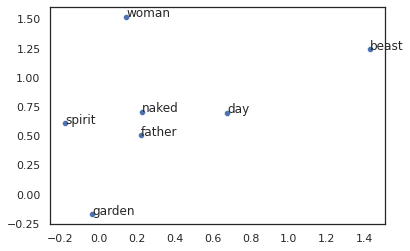

In [65]:
#Get the embeddings from the model
embeddings = Model.embedding_matrix.numpy()

#Get the indices of the example words
word_indices = [vocab[word] for word in interesting_words]
print(word_indices)
#Get the embeddings of the example words
word_embeddings = embeddings[word_indices]

#Plot the word embeddings in 2D space
sns.set(style='white')
sns.scatterplot(x=word_embeddings[:,0], y=word_embeddings[:,1])

for x,y,word,idx in zip(word_embeddings[:,0], word_embeddings[:,1], interesting_words, word_indices) : 
  plt.text(x,y, word)
plt.show()

In [67]:
split_it = smaller_data.split()
Counter = Counter(split_it)
#most_common() produces k frequently encountered
#input values and their respective counts
most_occur = Counter.most_common(50)
most_occur = [word for word, count in most_occur]
print(most_occur)

['and', 'the', 'of', 'he', 'to', 'his', 'in', 'unto', 'that', 'i', 'said', 'a', 'thou', 'him', 'it', 'my', 'was', 'thee', 'lord', 'thy', 'for', 'god', 'be', 'is', 'shall', 'me', 'all', 'with', 'will', 'they', 'earth', 'abraham', 'not', 'from', 'which', 'them', 'her', 'she', 'son', 'upon', 'were', 'after', 'had', 'years', 'every', 'wife', 'this', 'sons', 'begat', 'have']


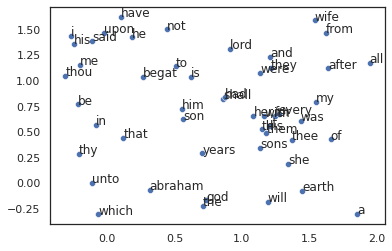

In [69]:
#Get the indices of the example words
word_indices = [vocab[word] for word in most_occur]
#Get the embeddings of the example words
word_embeddings = embeddings[word_indices]

#Plot the word embeddings in 2D space
sns.set(style='white')
sns.scatterplot(x=word_embeddings[:,0], y=word_embeddings[:,1])
for x,y,word,idx in zip(word_embeddings[:,0], word_embeddings[:,1], most_occur, word_indices) : 
  plt.text(x,y, word)
plt.show()